<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyze-progressive-differentiation-in-the-osteogenic-front" data-toc-modified-id="Analyze-progressive-differentiation-in-the-osteogenic-front-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyze progressive differentiation in the osteogenic front</a></span><ul class="toc-item"><li><span><a href="#Load-image" data-toc-modified-id="Load-image-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load image</a></span></li><li><span><a href="#Analyse-islands" data-toc-modified-id="Analyse-islands-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analyse islands</a></span><ul class="toc-item"><li><span><a href="#Summary-statistics" data-toc-modified-id="Summary-statistics-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Summary statistics</a></span></li></ul></li><li><span><a href="#Estimate-length-scale-of-differentiation-signal" data-toc-modified-id="Estimate-length-scale-of-differentiation-signal-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Estimate length scale of differentiation signal</a></span><ul class="toc-item"><li><span><a href="#Maximum-likelihood-estimate" data-toc-modified-id="Maximum-likelihood-estimate-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Maximum likelihood estimate</a></span><ul class="toc-item"><li><span><a href="#(1)-Project-each-island-onto-interface" data-toc-modified-id="(1)-Project-each-island-onto-interface-1.3.1.1"><span class="toc-item-num">1.3.1.1&nbsp;&nbsp;</span>(1) Project each island onto interface</a></span></li><li><span><a href="#(2)-Distance-to-average-interface-position" data-toc-modified-id="(2)-Distance-to-average-interface-position-1.3.1.2"><span class="toc-item-num">1.3.1.2&nbsp;&nbsp;</span>(2) Distance to average interface position</a></span></li></ul></li></ul></li><li><span><a href="#Nearest-neighbour-distances" data-toc-modified-id="Nearest-neighbour-distances-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Nearest-neighbour distances</a></span></li></ul></li></ul></div>

# Analyze progressive differentiation in the osteogenic front

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pandas import DataFrame
from numpy import fft
import os
cwd = os.getcwd(); print("Working dir: " + cwd)
save_folder = os.path.split(cwd)[0] + "/Figures/"; print("Save plots in: " + save_folder)

Working dir: /Users/dang/Documents/TablerLab/Code
Save plots in: /Users/dang/Documents/TablerLab/Figures/


In [2]:
# Image settings
size = np.array([593.74, 758.12]); # total size of image in microns
pix_per_micron = 9.6355; # number of pixels per micron

In [3]:
# Make plots interactive
%matplotlib notebook
# For 3D plots:
# %matplotlib widget

In [4]:
# Make plots static 
%matplotlib inline

## Load image

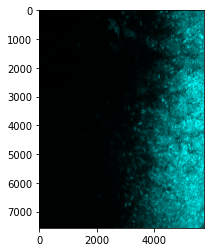

In [6]:
# Load image
im_path = "/Users/dang/Documents/TablerLab/Data_fixed_tissue/Data_Adrian_270120/";
im_fname = "270120_mTmG_OsxCRE_FrontImaging_MaxIntensity_processed_YD_adjusted";
im_label = "270120_mTmG_OsxCRE_"; # label for image, used for saving results
ext = ".tif";
img=mpimg.imread(im_path + im_fname + ext)
imgplot = plt.imshow(img)

## Analyse islands
<b>Goal</b>: determine distribution and properties of cells ahead of the front. <br>
<b>Hypothesis</b>: distribution is not exponential, because differentiation is a cooperative phenomenon.<br>
<b>Method</b>: Use Cell Counter in Fiji to manually label the (xy-position of the) outlying islands. Analyze results.

In [49]:
# Load XY positions from saved file
fname_in = "/Users/dang/Documents/TablerLab/Data_fixed_tissue/Data_Adrian_270120/Data_islands/270120_Cell_counter_islands_Osx1GFP_maxIntensity.csv";
data_islands = pd.read_csv(fname_in, header = None, delimiter = ";");
data_islands = data_islands/pix_per_micron; # express distances in microns
# flip x axis
data_islands[0] = Lx/pix_per_micron - data_islands[0];

In [42]:
# Load interface data from saved file (new method, from binary tiff file)
folder_in = "/Users/dang/Documents/TablerLab/Data_fixed_tissue/Data_Adrian_270120/Data_interfaces/"
fname_in = "270120_Interface_processed_YD_tolerance_10000_sample_1.txt"

data_image = pd.read_csv(folder_in + fname_in, header = None, delimiter='\t');
data_image[data_image == 255] = 1; # convert to 0/1    
Lx= data_image.shape[1]; 
Ly= data_image.shape[0]; 

# flip x-axis?
reverse = 0;    

# Define interface (same as above)
if reverse:
    data_image_rev = np.empty(data_image.shape);
    for i in np.arange(0, data_image.shape[0]):
        # print(i)
        data_image_rev[i] = data_image.iloc[i][::-1];
    interface = np.array(data_image_rev.argmax(axis=1), dtype=float); # find (first) index of max. of data frame
else:
    interface = np.array(data_image.idxmax(axis=1), dtype=float); # find (first) index of max. of data frame

# Check that none of the rows has only 0 or 1:
if len(interface[interface == 0])==0:
    print("No empty/full rows")
else:
    print("Empty/full rows detected!") 
    # post-processing: delete empty/full rows
    mask = np.array(interface == 0, dtype=bool);
    interface[mask] = np.nan; # remove bad rows

# flip x-axis so tissue evolves to right
interface = Lx - interface; 

# --- Load interface data from saved file (old method) ---
# folder_in = "/Users/dang/Documents/TablerLab/Data_fixed_tissue/Data_Adrian_270120/Data_interfaces/"
# fname_in = "270120_Interface_processed_threshold_auto_removed_outliers_radius_20_contiguous_region.txt"
# data_interface = pd.read_csv(folder_in+fname_in, header = None, delimiter = '\t');

# def process_interface(data_interface, margins):
#     ymax = max(data_interface[1]);
#     ymin = min(data_interface[1]);
#     xmax = max(data_interface[0]);
#     cond = ~(((round(data_interface[1])>=round(ymax)-margins[0]) | (round(data_interface[1])<=round(ymin)+margins[1]) | (round(data_interface[0])>=round(xmax)-margins[2])));
#     mydata_interface = DataFrame.to_numpy(data_interface[:][cond]);
#     return mydata_interface

# # slice data
# mydata_interface = process_interface(data_interface, margins).T;

No empty/full rows


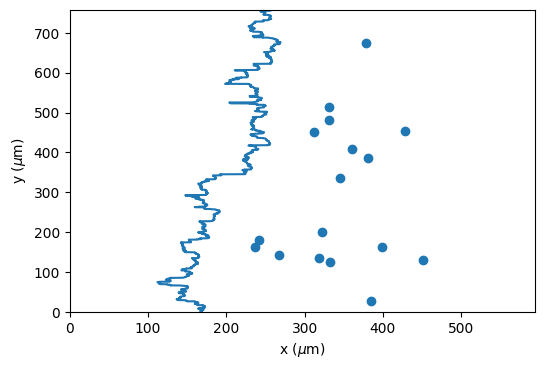

In [51]:
# Plot islands together with interface
h = plt.figure(2, dpi = 100);
p1 = plt.plot(interface/pix_per_micron, np.arange(Ly)/pix_per_micron, label='Interface');
p2 = plt.scatter(data_islands[0], data_islands[1], label='Islands');
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.xlim(0, size[0])
plt.ylim(0, size[1])
#plt.legend([p1,p2], ["A", "B"])

# Save image
# fname_out = save_folder + im_label + "interface_w_islands";
# ext = ".png";
# plt.savefig(fname_out + ext)

plt.show();

### Summary statistics

In [9]:
print("Number of islands N_i = " + str(data_islands.shape[0]) )
print("Island density N_i/L = " + str(round(data_islands.shape[0]/size[0], 3)) + " islands per micron" )

Number of islands N_i = 17
Island density N_i/L = 0.029 islands per micron


## Estimate length scale of differentiation signal

Assuming the signal comes from the bone / osteoblasts, and decays exponentially from the front

### Maximum likelihood estimate

#### (1) Project each island onto interface

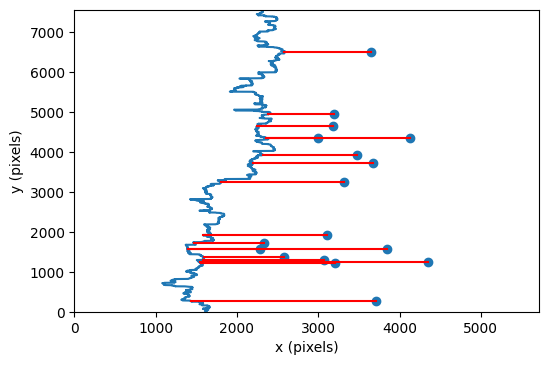

In [98]:
# (1) Project each island onto interface
delta_x_all_pix = np.zeros(data_islands.shape[0]);

h = plt.figure(2, dpi = 100);
p1 = plt.plot(interface, np.arange(Ly), label='Interface');
p2 = plt.scatter(data_islands[0]*pix_per_micron, data_islands[1]*pix_per_micron, label='Islands');
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
for i in range(data_islands.shape[0]):
    #i=2;
    y_island = int(data_islands[1][i]*pix_per_micron)
    x_interface = interface[y_island]
    delta_x = (int(data_islands[0][i]*pix_per_micron) - x_interface);
    delta_x_all_pix[i] = delta_x;
    plt.plot([x_interface, x_interface+delta_x], [y_island, y_island], 'r')
plt.xlim(0, Lx)
plt.ylim(0, Ly)
plt.show();

Lambda (MLE) =  0.006750886086383119
Lambda (MLE), unbiased =  0.006353775140125289
Average distance to front:  148.12870298864186  microns


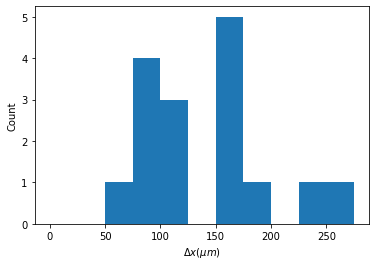

In [122]:
# maximum likelihood estimator
delta_x_all = delta_x_all_pix/pix_per_micron;
lambda_mle = data_islands.shape[0]/np.sum(delta_x_all);
lambda_mle_ub = (data_islands.shape[0]-1)/np.sum(delta_x_all); # unbiased estimator

print('Lambda (MLE) = ', lambda_mle)
print('Lambda (MLE), unbiased = ', lambda_mle_ub)
print('Average distance to front: ', np.mean(delta_x_all), ' microns')

# Plot histogram with inferred distribution
plt.figure();
plt.hist(delta_x_all, np.arange(0, 300, 25) )
x_plot = np.arange(0, 300)
#plt.plot(x_plot, np.exp(-x_plot/lambda_mle_ub)/lambda_mle )
plt.xlabel('$\Delta x (\mu m)$')
plt.ylabel('Count')
plt.show();

#### (2) Distance to average interface position

Average distance to front:  136.82306317760901  microns


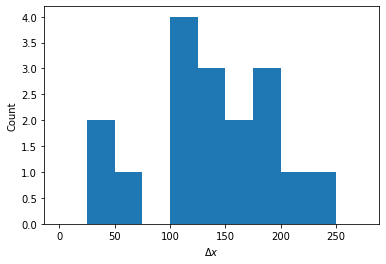

In [121]:
x_interface = np.mean(interface);
delta_x_all_pix2 = np.array(data_islands[0]*pix_per_micron) - x_interface;
delta_x_all2 = delta_x_all_pix2/pix_per_micron
print('Average distance to front: ', np.mean(delta_x_all2), ' microns')

# Plot histogram
plt.figure();
plt.hist(delta_x_all2, np.arange(0, 300, 25) )
plt.xlabel('$\Delta x$')
plt.ylabel('Count')
plt.show();

## Nearest-neighbour distances

In [10]:
# Compute NN distances
x_all = data_islands[0];
y_all = data_islands[1];
x_all = x_all[:, np.newaxis]; # add axis to array
y_all = y_all[:, np.newaxis];
dy_all = np.abs(y_all.T - y_all); # all distances in y
d_all = np.sqrt((x_all.T - x_all)**2 + (y_all.T - y_all)**2); # Euclidean distances
dy_min_all = np.sort(dy_all, 1)[:, 2]; # Nearest distance in y
d_min_all = np.sort(d_all, 1)[:, 2]; # Nearest Euclidean distance
#print(d_min_all)

<ipython-input-10-4dec4cf5db6a>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_all = x_all[:, np.newaxis]; # add axis to array
<ipython-input-10-4dec4cf5db6a>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_all = y_all[:, np.newaxis];


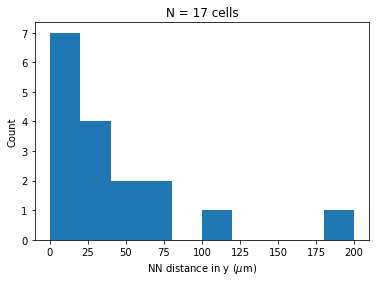

In [11]:
# Plot distribution
fig = plt.figure()
plt.hist(dy_min_all, bins=np.arange(0, 201, 20))
plt.xlabel('NN distance in y ($\mu$m)')
plt.ylabel('Count')
plt.title('N = ' + str(data_islands[0].size) + ' cells')

# Save image
fname_out = save_folder + im_label + "Islands_NN_Distribution";
ext = ".png";
plt.savefig(fname_out + ext)

plt.show()

# Summary statistics
dy_min_all_df = pd.DataFrame(dy_min_all, columns=['Data'])
#print(dy_min_all_df.describe())

<b>Observation</b>: distribution could still approximate exponential, but we need far more statistics to determine this.